In [31]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import linregress
import matplotlib.patches as patches

import WetBulb

GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [32]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

def CtoF(x):
    return x*9/5 + 32

# Load data

In [33]:
file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
    
    if year <= 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_PBE_historical_an-sfc_' + str(year) + '_0UTC.nc'
    
    if year > 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_historical_an-sfc_' + str(year) + '_0UTC.nc'
        
    filenames.append(file_name)

# Open all files
temp_dailymax = xr.open_mfdataset(filenames)

In [34]:
temp_dailymax = temp_dailymax.rename_vars({'T': 't2m'})

In [35]:
# Just open 2023 data

file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

temp_2023 = xr.open_mfdataset(file_dir + 'T_daily_max_ERA5_historical_an-sfc_2023_0UTC.nc')

In [36]:
# Combine ERA5 and ERA5T
temp2023_ERA5 = temp_2023.sel(expver=1)

temp2023_ERA5T = temp_2023.sel(expver = 5)

In [37]:
temp2023_ERA5 = temp2023_ERA5.isel(time = slice(0, 304))
temp2023_ERA5T = temp2023_ERA5T.isel(time = slice(304,366))

In [38]:
temp2023_combined = xr.combine_by_coords([temp2023_ERA5,temp2023_ERA5T])

In [39]:
# Historical data
temp_combined = xr.combine_by_coords([temp_dailymax,temp2023_combined.drop_vars('expver')])

In [40]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'

galeao = xr.open_dataset(stn_folder + galeao_name)

In [41]:
# Grid cell closest to Rio station location
lon_grid, lat_grid = np.meshgrid(temp_combined.longitude.values, temp_combined.latitude.values)
distances = np.sqrt((lon_grid - (galeao.longitude.values + 360))**2 + (lat_grid - galeao.latitude.values)**2)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

# Get the longitude and latitude of the closest grid cell
closest_lon = temp_combined.longitude.values[min_index[1]]
closest_lat = temp_combined.latitude.values[min_index[0]]

In [42]:
temp_rio = temp_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])

In [43]:
temp_rio.load()

<xarray.Dataset>
Dimensions:  (time: 16436)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
Data variables:
    t2m      (time) float32 307.1 302.5 304.2 298.9 ... 303.3 309.4 302.3 298.1

# Test figure with static threshold

In [44]:
# Start with ERA5 data for Rio specifically
rio_temp = temp_rio.t2m

thresh = 34
ERA5_T_above_thresh = rio_temp[rio_temp > thresh + 273.15]

In [45]:
from dateutil.relativedelta import relativedelta

# Shift time by 6 months back so that don't have discontinuity across Dec/Jan
time_shifted = pd.DatetimeIndex(ERA5_T_above_thresh.time.values - np.timedelta64(180,'D'))
ERA5_T_above_thresh['shifted_time'] = (['time'],time_shifted)

first_days = []
last_days = []

# Find first and last 32C day each year
for i in range(len(np.unique(time_shifted.year))):

    year = np.unique(time_shifted.year)[i]
    annual_heatdays = ERA5_T_above_thresh['shifted_time'][time_shifted.year == year]
    first_days.append([annual_heatdays.isel(time = 0).time.values])
    last_days.append([annual_heatdays.isel(time = -1).time.values])

In [46]:
first_trunc = first_days[1:-1]
last_trunc = last_days[1:-1]

In [47]:
ERA5_T_above_thresh

<xarray.DataArray 't2m' (time: 1069)>
array([307.27914, 307.22467, 307.20383, ..., 307.77808, 307.1709 ,
       309.4473 ], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-28 1979-03-10 ... 2023-12-29
    shifted_time  (time) datetime64[ns] 1978-08-01 1978-09-11 ... 2023-07-02

In [48]:
def day_of_year(datetime_value):
    # Convert the datetime64 value to a datetime object
    dt = str(np.squeeze(np.datetime_as_string(datetime_value, unit='D')))  # Convert to string with 'D' unit
    dt_obj = np.datetime64(dt)
    
    # Get the ordinal day of the year (1st January is day 1)
    day_of_year = (dt_obj - np.datetime64(dt_obj.astype('datetime64[Y]'))).astype(int) + 1
    
    return day_of_year

Text(0, 0.5, 'Year Season Starts')

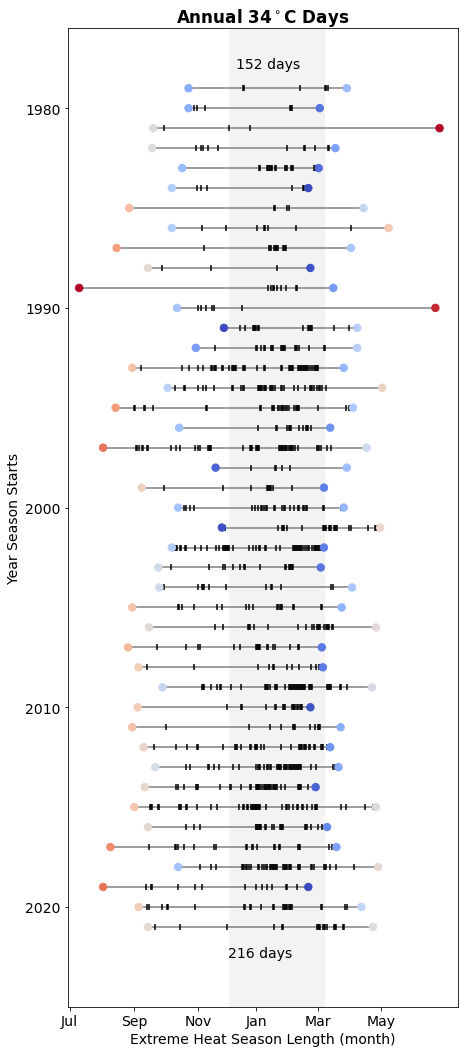

In [49]:
first_DOYs = []
last_DOYs = []

for i in range(len(first_trunc) - 1):

    first_day = first_trunc[i]
    last_day = last_trunc[i]

    first_DOY = day_of_year(first_day)
    last_DOY = day_of_year(last_day)
    
    if first_DOY > 180:
        first_DOY = first_DOY - 180
    if last_DOY < 180:
        last_DOY = last_DOY + 180
        
    first_DOYs.append(first_DOY)
    last_DOYs.append(last_DOY)
    
season_length = np.array(last_DOYs) - np.array(first_DOYs)

# Make line thickness reflect season length
order = season_length.argsort()
ranks = order.argsort()
frac = (ranks+1)/len(ranks)
linewidths = 1 + frac*6

# Plot
plt.rcParams.update({'font.size': 14})

x_ax = np.concatenate((np.arange(180,367,1),np.arange(1,180,1)), axis = 0)
y_ax = np.arange(1979,2023,1)

fig, axs = plt.subplots(1,1, figsize = (7,18))
axs.set_xlim([0,375])
axs.set_ylim([2025,1976])
axs.set_title('Annual ' + str(thresh) + '$^\circ$C Days', fontweight = 'bold')

xlabels = ['Jul','Sep','Nov','Jan','Mar','May']
xlabel_vals = [182-180,244-180,305-180,1 + 180,60 + 180,121+180]

axs.set_xticks(xlabel_vals)
axs.set_xticklabels(xlabels)

for i in range(len(first_trunc) - 1):

    axs.hlines(y_ax[i],first_DOYs[i],last_DOYs[i], color = 'grey') #linewidth = linewidths[i]
    
    if i == 0:
        axs.text((first_DOYs[i] + last_DOYs[i])/2, 1978, str(season_length[i]) + ' days', horizontalalignment = 'center')
        
    if i == (len(first_trunc) - 2):
        axs.text((first_DOYs[i] + last_DOYs[i])/2, 2022.5, str(season_length[i]) + ' days', horizontalalignment = 'center')

        
first_scat = axs.scatter(first_DOYs,y_ax[:-1], c = first_DOYs, cmap = 'coolwarm_r', s = 55, marker = 'o',zorder = 10)
last_scat = axs.scatter(last_DOYs,y_ax[:-1], c = last_DOYs, cmap = 'coolwarm', s = 55, marker = 'o',zorder = 10)

# Plot scatter for all events over 34 per year
for i in range(len(np.unique(time_shifted.year))-2):

    year = np.unique(time_shifted.year)[i]
    annual_heatdays = ERA5_T_above_thresh['shifted_time'][time_shifted.year == year]
    annual_dates = annual_heatdays.time.values
    annual_trunc = annual_dates[1:-1]

    heatwaves_DOY = [day_of_year(x) for x in annual_trunc]
    
    y_plot = year*np.ones(len(heatwaves_DOY))
    
    for i, heatwave in enumerate(heatwaves_DOY):
        if heatwave > 180:
            heatwaves_DOY[i] = heatwave -180
        if heatwave <= 180:
            heatwaves_DOY[i] = heatwave + 180
    
    heatdays_scat = axs.scatter(heatwaves_DOY,y_plot, c = 'k', s = 45, marker = '|',zorder = 5)
    
# Shade DJF
p1 = plt.Rectangle((335-180, 1970), 31+31+30, 80, fill=True, facecolor = 'lightgrey',edgecolor = None, alpha = 0.25, zorder = 1)
axs.add_patch(p1)

axs.set_xlabel('Extreme Heat Season Length (month)')
axs.set_ylabel('Year Season Starts')

# Figure 8

In [50]:
# Find hottest months
monthly_mean_temp = rio_temp.groupby('time.month').mean()
monthly_mean_temp.values

# This shows that January and February are the hottest months, historically

# Calculate the 85th percentiles across these months for the new threshold
rio_JF = rio_temp.sel(time = rio_temp.time.dt.month.isin([1,2]))
rio_JF50 = rio_JF.quantile(0.5).values
print(rio_JF50 - 273.15)

31.392083740234398


In [51]:
rio_temp = temp_rio.t2m
thresh = rio_JF50
hw_length = 3

from dateutil.relativedelta import relativedelta

# Shift time by 6 months back so that don't have discontinuity across Dec/Jan
time_shifted = pd.DatetimeIndex(rio_temp.time.values - np.timedelta64(180,'D'))
rio_temp['shifted_time'] = (['time'],time_shifted)

df = rio_temp.to_dataframe()

first_days = []
last_days = []

# Find first and last 32C day each year
for i in range(len(np.unique(time_shifted.year))):

    year = np.unique(time_shifted.year)[i]
    annual_data = df[time_shifted.year == year]
    
    # Find heatwave days and persistence
    annual_data['heat_days'] = (annual_data.t2m >= thresh)
    annual_data['cross_heat_days'] = (annual_data['heat_days'] != annual_data['heat_days'].shift()).cumsum()
    annual_data['count_heat_days'] = annual_data.groupby(['heat_days', 'cross_heat_days']).cumcount(ascending=False) + 1
    annual_data.loc[annual_data.heat_days == False, 'count_heat_days'] = 0

    # Identify heatwaves -- this will take all but the last day of any heatwave; start date is good, for the last date need to add one (one day later)
    heatwaves = annual_data.loc[(annual_data['count_heat_days'] >= hw_length)]
    
    if len(heatwaves) > 0:
        first_days.append(heatwaves.iloc[0].shifted_time.to_numpy())
        last_days.append(heatwaves.iloc[-1].shifted_time.to_numpy())
    else:
        first_days.append(np.nan)
        last_days.append(np.nan)

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [52]:
first_trunc = first_days[1:]
last_trunc = last_days[1:]

In [53]:
ERA5_T_above_thresh = rio_temp[rio_temp > thresh]

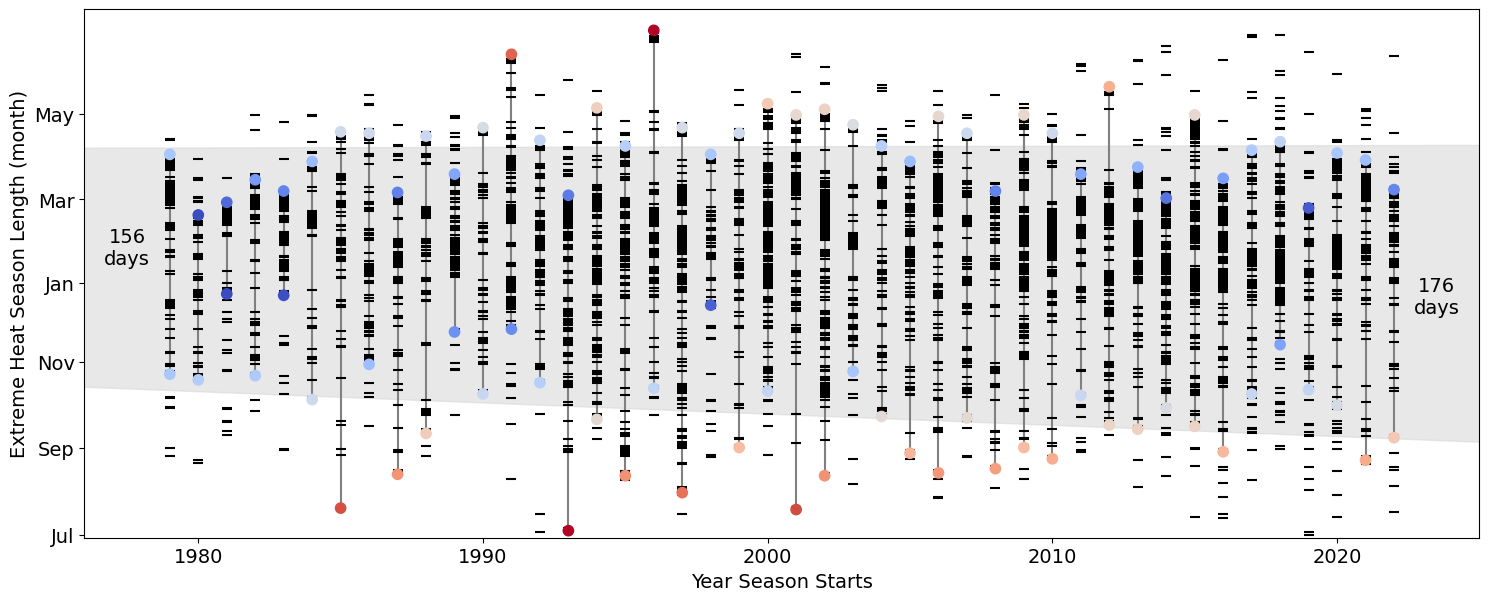

In [54]:
first_DOYs = []
last_DOYs = []

for i in range(len(first_trunc) - 1):

    first_day = first_trunc[i]
    last_day = last_trunc[i]

    first_DOY = day_of_year(first_day)
    last_DOY = day_of_year(last_day)
    
    if first_DOY > 180:
        first_DOY = first_DOY - 180
    if last_DOY < 180:
        last_DOY = last_DOY + 180 + hw_length -1 #note that the code above records the day before the last day, need to add one
        
    first_DOYs.append(first_DOY)
    last_DOYs.append(last_DOY)
    
season_length = np.array(last_DOYs) - np.array(first_DOYs)

# Make line thickness reflect season length
order = season_length.argsort()
ranks = order.argsort()
frac = (ranks+1)/len(ranks)
linewidths = 1 + frac*6

# Plot
plt.rcParams.update({'font.size': 14})

y_ax = np.concatenate((np.arange(180,367,1),np.arange(1,180,1)), axis = 0)
x_ax = np.arange(1979,2023,1)

fig, axs = plt.subplots(1,1, figsize = (18,7), dpi = 100)
axs.set_ylim([0,375])
axs.set_xlim([1976,2025])

ylabels = ['Jul','Sep','Nov','Jan','Mar','May']
ylabel_vals = [182-180,244-180,305-180,1 + 180,60 + 180,121+180]

axs.set_yticks(ylabel_vals)
axs.set_yticklabels(ylabels)

for i in range(len(first_trunc) - 1):

    axs.vlines(x_ax[i],first_DOYs[i],last_DOYs[i], color = 'grey') #linewidth = linewidths[i]
    
    if i == 0:
        axs.text(1977.5,(first_DOYs[i] + last_DOYs[i])/2, str(season_length[i]) + '\ndays', horizontalalignment = 'center')
        
    if i == (len(first_trunc) - 2):
        axs.text(2023.5, (first_DOYs[i] + last_DOYs[i])/2, str(season_length[i]) + '\ndays', horizontalalignment = 'center')

        
first_scat = axs.scatter(x_ax,first_DOYs, c = first_DOYs, cmap = 'coolwarm_r', s = 55, marker = 'o',zorder = 10)
last_scat = axs.scatter(x_ax,last_DOYs, c = last_DOYs, cmap = 'coolwarm', s = 55, marker = 'o',zorder = 10)

# Plot scatter for all events over 32 per year

for i in range(len(np.unique(time_shifted.year))-2):

    year = np.unique(time_shifted.year)[i+1]
    annual_heatdays = ERA5_T_above_thresh['shifted_time'][ERA5_T_above_thresh.shifted_time.dt.year == year]
    annual_dates = annual_heatdays.time.values
    annual_trunc = annual_dates[1:]

    heatwaves_DOY = [day_of_year(x) for x in annual_trunc]
    
    x_plot = year*np.ones(len(heatwaves_DOY))
    
    for i, heatwave in enumerate(heatwaves_DOY):
        if heatwave > 180:
            heatwaves_DOY[i] = heatwave -180
        if heatwave <= 180:
            heatwaves_DOY[i] = heatwave + 180
    
    heatdays_scat = axs.scatter(x_plot, heatwaves_DOY, c = 'k', s = 45, marker = '_',zorder = 5)


axs.set_ylabel('Extreme Heat Season Length (month)')
axs.set_xlabel('Year Season Starts')

# Add best fit lines
x_corr = np.arange(1950,2030,1)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x_ax, first_DOYs)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x_ax, last_DOYs)

axs.fill_between(x_corr, slope1 * x_corr + intercept1, slope2 * x_corr + intercept2, color = 'lightgrey',alpha = 0.5)

#plt.savefig('/home/ivanov/jupyternb/Brazil_Heatwave/Final Figures for Upload/Figure8.png')

plt.show()